In [10]:
import pandas as pd
import psycopg2


sqluser = 'postgres'
dbname = 'mimic'
schema_name = 'mimiciii'

# Password keyword only necessary if user-specified password required to connect to database
con = psycopg2.connect(dbname=dbname, user=sqluser, password='postgre')
cur = con.cursor()

query = "SELECT" \
        " a.subject_id, a.hadm_id, a.ethnicity, a.insurance, p.gender" \
        ", ROUND( (cast(a.admittime as date) - cast(p.dob as date)) / 365.242)" \
        " AS age_on_admiss" \
        ", cast(a.dischtime as date) - cast(a.admittime as date)" \
        " AS length_of_stay" \
        " FROM admissions a" \
        " INNER JOIN patients p" \
        " ON p.subject_id = a.subject_id" \
        " GROUP BY" \
        " a.subject_id, a.hadm_id, a.ethnicity, a.insurance, p.gender, a.admittime, p.dob, a.dischtime" \
        " ORDER BY a.subject_id;"

cur.execute('SET search_path to ' + schema_name)
df = pd.read_sql_query(query, con)

print(df.head(5))

   subject_id  hadm_id ethnicity insurance gender  age_on_admiss  \
0           2   163353     ASIAN   Private      M            0.0   
1           3   145834     WHITE  Medicare      M           77.0   
2           4   185777     WHITE   Private      F           48.0   
3           5   178980     ASIAN   Private      M            0.0   
4           6   107064     WHITE  Medicare      F           66.0   

   length_of_stay  
0               4  
1              11  
2               7  
3               2  
4              16  


In [17]:
%%time

# Code adapted from https://github.com/MIT-LCP/mimic-code/blob/master/concepts/pivot/pivoted-vital.sql
query_vitals = """ with ce as
(
  select ce.hadm_id
    , ce.charttime
    , (case when itemid in (211,220045) and valuenum > 0 and valuenum < 300 then valuenum else null end) as HeartRate
    , (case when itemid in (51,442,455,6701,220179,220050) and valuenum > 0 and valuenum < 400 then valuenum else null end) as SysBP
    , (case when itemid in (615,618,220210,224690) and valuenum > 0 and valuenum < 70 then valuenum else null end) as RespRate
    , (case when itemid in (223761,678) and valuenum > 70 and valuenum < 120 then (valuenum-32)/1.8 -- converted to degC in valuenum call
               when itemid in (223762,676) and valuenum > 10 and valuenum < 50  then valuenum else null end) as TempC
    , (case when itemid in (646,220277) and valuenum > 0 and valuenum <= 100 then valuenum else null end) as SpO2
  from mimiciii.chartevents ce
  -- exclude rows marked as error
  where ce.error IS DISTINCT FROM 1
  and ce.itemid in
  (
  -- HEART RATE
  211, --"Heart Rate"
  220045, --"Heart Rate"

  -- Systolic

  51, --	Arterial BP [Systolic]
  442, --	Manual BP [Systolic]
  455, --	NBP [Systolic]
  6701, --	Arterial BP #2 [Systolic]
  220179, --	Non Invasive Blood Pressure systolic
  220050, --	Arterial Blood Pressure systolic

  -- RESPIRATORY RATE
  618,--	Respiratory Rate
  615,--	Resp Rate (Total)
  220210,--	Respiratory Rate
  224690, --	Respiratory Rate (Total)


  -- SPO2, peripheral
  646, 220277,


  -- TEMPERATURE
  223762, -- "Temperature Celsius"
  676,	-- "Temperature C"
  223761, -- "Temperature Fahrenheit"
  678 --	"Temperature F"

  )
)
select
    ce.hadm_id
  , ce.charttime
  , avg(HeartRate) as HeartRate
  , avg(SysBP) as SysBP
  , avg(RespRate) as RespRate
  , avg(TempC) as TempC
  , avg(SpO2) as SpO2
from ce
group by ce.hadm_id, ce.charttime
order by ce.hadm_id, ce.charttime;"""

df_vitals = pd.read_sql_query(query_vitals, con)

print(df_vitals.head(5))

   hadm_id           charttime  heartrate  sysbp  resprate      tempc  spo2
0   100001 2117-09-11 12:57:00      122.0    NaN      14.0        NaN   NaN
1   100001 2117-09-11 13:00:00      118.0    NaN      22.0        NaN   NaN
2   100001 2117-09-11 13:01:00        NaN  192.0       NaN        NaN   NaN
3   100001 2117-09-11 13:48:00        NaN    NaN       NaN  36.666667   NaN
4   100001 2117-09-11 13:50:00      118.0    NaN      22.0        NaN   NaN
CPU times: user 18.6 s, sys: 6.89 s, total: 25.5 s
Wall time: 2min 13s


In [5]:
df_vitals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8627341 entries, 0 to 8627340
Data columns (total 7 columns):
icustay_id    float64
charttime     datetime64[ns]
heartrate     float64
sysbp         float64
resprate      float64
tempc         float64
spo2          float64
dtypes: datetime64[ns](1), float64(6)
memory usage: 460.7 MB


In [26]:
merge_df = df.merge(df_vitals, on = "hadm_id", how = "inner")

In [27]:
merge_df.head(5)

,subject_id,hadm_id,ethnicity,insurance,gender,age_on_admiss,length_of_stay,charttime,heartrate,sysbp,resprate,tempc,spo2
0,2,163353,ASIAN,Private,M,0.0,4,2138-07-17 20:20:00,148.0,NaN,NaN,NaN,NaN
1,2,163353,ASIAN,Private,M,0.0,4,2138-07-17 20:30:00,131.0,NaN,NaN,NaN,NaN
2,2,163353,ASIAN,Private,M,0.0,4,2138-07-17 21:00:00,144.0,NaN,NaN,NaN,NaN
3,2,163353,ASIAN,Private,M,0.0,4,2138-07-17 22:00:00,140.0,NaN,NaN,NaN,NaN
4,3,145834,WHITE,Medicare,M,77.0,11,2101-10-20 18:30:00,NaN,NaN,NaN,36.055556,NaN


In [28]:
merge_df.isnull().sum()

subject_id              0
hadm_id                 0
ethnicity               0
insurance               0
gender                  0
age_on_admiss           0
length_of_stay          0
charttime               0
heartrate          688687
sysbp             2844883
resprate          2350596
tempc             6892769
spo2              2542725
dtype: int64

In [29]:
merge_df.shape

(8627341, 13)

In [30]:
merge_df.describe()

,subject_id,hadm_id,age_on_admiss,length_of_stay,heartrate,sysbp,resprate,tempc,spo2
count,8.627341e+06,8.627341e+06,8.627341e+06,8.627341e+06,7.938654e+06,5.782458e+06,6.276745e+06,1.734572e+06,6.084616e+06
mean,3.300434e+04,1.498434e+05,5.897300e+01,2.766516e+01,1.014212e+02,1.215081e+02,2.020785e+01,3.700469e+01,9.708009e+01
std,2.785872e+04,2.874910e+04,5.305239e+01,2.898572e+01,3.279940e+01,2.368802e+01,6.043783e+00,8.432616e-01,3.495221e+00
min,2.000000e+00,1.000010e+05,0.000000e+00,0.000000e+00,1.460000e-01,6.000000e-02,1.700000e-01,1.500000e+01,5.000000e-01
25%,1.156300e+04,1.253430e+05,3.700000e+01,9.000000e+00,7.800000e+01,1.040000e+02,1.600000e+01,3.644444e+01,9.600000e+01
50%,2.348300e+04,1.491550e+05,6.100000e+01,1.800000e+01,9.200000e+01,1.190000e+02,2.000000e+01,3.700000e+01,9.800000e+01
75%,5.255000e+04,1.749130e+05,7.500000e+01,3.500000e+01,1.190000e+02,1.370000e+02,2.400000e+01,3.755555e+01,9.900000e+01
max,9.999900e+04,1.999990e+05,3.100000e+02,2.950000e+02,2.920000e+02,3.550000e+02,6.900000e+01,4.650000e+01,1.000000e+02


In [36]:
merge_agg_df = merge_df.groupby('hadm_id').agg('mean')


In [31]:
list(merge_df)

['subject_id',
 'hadm_id',
 'ethnicity',
 'insurance',
 'gender',
 'age_on_admiss',
 'length_of_stay',
 'charttime',
 'heartrate',
 'sysbp',
 'resprate',
 'tempc',
 'spo2']

In [37]:
merge_agg_df.isnull().sum()

subject_id           0
age_on_admiss        0
length_of_stay       0
heartrate           12
sysbp             7693
resprate          7708
tempc             7825
spo2              7727
dtype: int64

In [38]:
merge_agg_df.describe()

,subject_id,age_on_admiss,length_of_stay,heartrate,sysbp,resprate,tempc,spo2
count,56725.000000,56725.000000,56725.000000,56713.000000,49032.000000,49017.000000,48900.000000,48998.000000
mean,33889.740467,64.718431,10.221966,92.589150,120.829083,19.118249,36.833328,96.879525
std,28162.107130,57.375131,12.562837,24.235403,16.310950,3.594148,0.546761,2.429015
min,2.000000,0.000000,0.000000,29.916667,29.166667,7.000000,30.000000,31.444444
25%,12028.000000,44.000000,4.000000,76.681818,109.244127,16.560606,36.501409,96.045455
50%,24204.000000,62.000000,7.000000,86.863636,119.056187,18.685039,36.819444,97.200000
75%,54247.000000,76.000000,12.000000,100.232955,131.143908,21.233129,37.162901,98.205128
max,99999.000000,310.000000,295.000000,244.800000,215.833333,45.500000,40.833333,100.000000


In [43]:
(merge_agg_df.isnull().sum()/merge_agg_df.count())* 100

subject_id         0.000000
age_on_admiss      0.000000
length_of_stay     0.000000
heartrate          0.021159
sysbp             15.689754
resprate          15.725157
tempc             16.002045
spo2              15.770031
dtype: float64

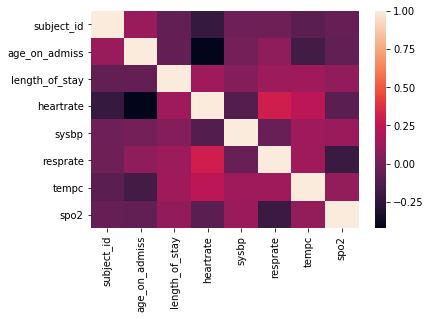

In [48]:
import seaborn as sns
import matplotlib
%matplotlib inline
corr = merge_agg_df.corr()
sns.heatmap(corr)


/Users/michaelalbuquerque/anaconda/envs/mimic/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


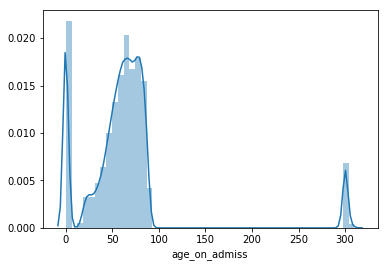

In [54]:
sns.distplot(merge_agg_df['age_on_admiss'])


In [56]:
import numpy as np
merge_agg_df['age_on_admiss'] = np.where(merge_agg_df['age_on_admiss']>100, 90, merge_agg_df['age_on_admiss'])

/Users/michaelalbuquerque/anaconda/envs/mimic/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


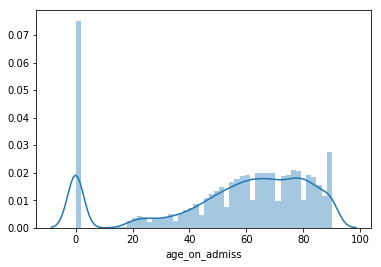

In [57]:
sns.distplot(merge_agg_df['age_on_admiss'])
